In [1]:
import torch
from omegaconf import OmegaConf
from PIL import Image

import einops
from clip2latent.models import load_models

checkpoint = "best.ckpt"
device = "cuda:7"
cfg_file = "best.yaml"
cfg = OmegaConf.load(cfg_file)

G, clip_model, trainer = load_models(cfg, device)

trainer.load_state_dict(torch.load(checkpoint, map_location="cpu")["state_dict"], strict=False)
diffusion_prior = trainer.diffusion_prior

/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompts = [
    "A photograph of a university graduate",
]


In [3]:
n_samples = 8
feat = clip_model.embed_text(prompts)
diffusion_prior.set_timestep_skip(100)
all_features = feat.tile(n_samples, 1)

all_pred = diffusion_prior.sample(all_features, cond_scale=3)


sampling loop time step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.56it/s]


In [4]:
scale = 1
n_examples = 16

with torch.no_grad():
    torch.manual_seed(0)
    out = G.synthesis(all_pred, noise_mode="const")


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [5]:
first = einops.rearrange(out, '(ncol nrow) c h w -> c (ncol h) (nrow w)', nrow=4)
grid = first.clamp(-1,1)*0.5 + 0.5
grid = Image.fromarray((255*grid).to(torch.uint8).permute(1,2,0).detach().cpu().numpy())
display_grid = grid.reduce(4)

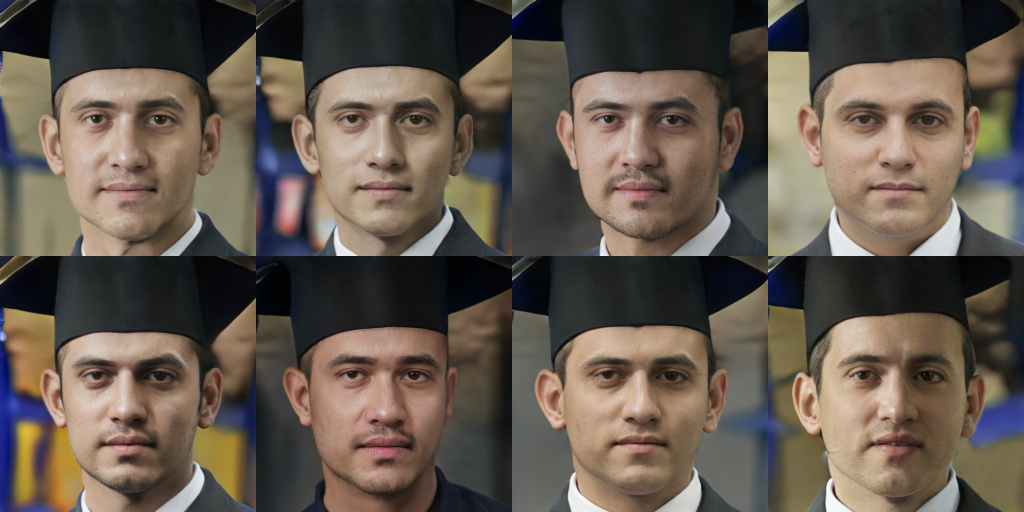

In [6]:
display_grid

In [7]:
with torch.no_grad():
    z = torch.randn(n_examples, 512, device=device)
    w = G.mapping(z, c=None, truncation_psi=0.7)
    
    select_layers = slice(7,-1)
    mod_w = all_pred[0].clone().unsqueeze(0).tile(n_samples, 1,1)
    mod_w[:, select_layers, :] = w[:n_samples, select_layers, :]
    
    out = G.synthesis(mod_w, noise_mode="const")

In [8]:
first = einops.rearrange(out, '(ncol nrow) c h w -> c (ncol h) (nrow w)', nrow=4)

grid = first.clamp(-1,1)*0.5 + 0.5
grid = Image.fromarray((255*grid).to(torch.uint8).permute(1,2,0).detach().cpu().numpy())
display_grid = grid.reduce(4)
grid.save("figures/mix.png")

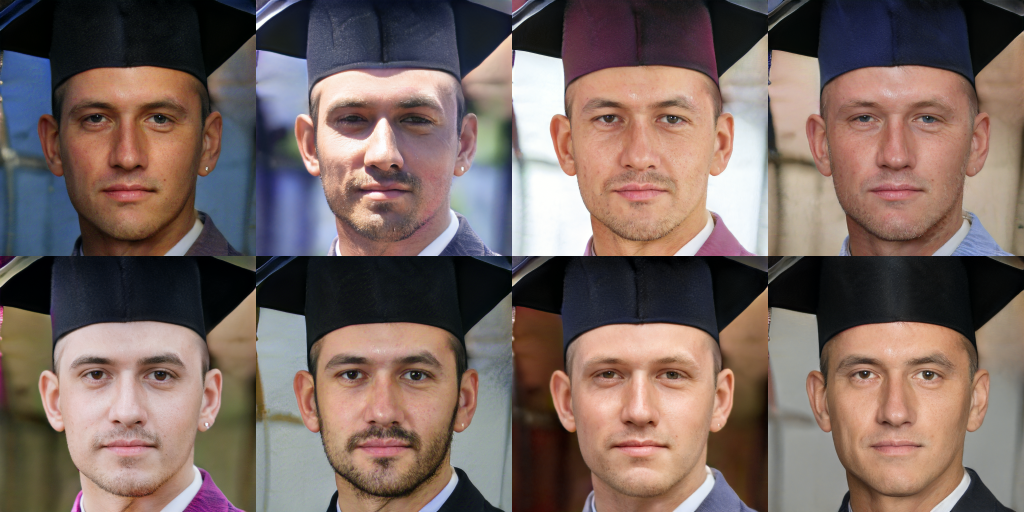

In [9]:
display_grid